#### This is an imporant notebook. Can be used to generate data reports for states

In [1]:
import os
import pandas as pd 
from datetime import datetime
import seaborn as sns

from pandas.plotting import table

In [2]:
import matplotlib.pyplot as plt

In [3]:
from src.utils.general import get_db_conn

In [4]:
creds_folder = '../conf/local/'
fpath = os.path.join(creds_folder, 'credentials.yaml')
db_con = get_db_conn(fpath)

### State being analysed

In [49]:
state = 'VT' 

### Sessions for the state

Only considering regular sessions in this 

In [50]:
q = """
    select 
        distinct session_id, 
        year_start,
        year_end,
        session_title
    from clean.bills 
        join clean.sessions using(session_id) 
    where state='{}' and not special
    order by year_start
    """.format(state)

In [51]:
t = pd.read_sql(q, db_con)
t

,session_id,year_start,year_end,session_title
0,46,2009,2010,"""Regular Session"""
1,94,2011,2012,"""Regular Session"""
2,1021,2013,2014,"""Regular Session"""
3,1151,2015,2016,"""Regular Session"""
4,1264,2017,2018,"""Regular Session"""
5,1652,2019,2020,"""Regular Session"""


In [52]:
# fig, ax = plt.subplots()
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# # table(ax, t)

### What is the Data distribution across time for the state?

In [53]:
q = """
    select 
        introduced_date,
        count(*) as num_bills
    from clean.bills 
        join clean.sessions using(session_id) 
    where state='{}' and not special
    group by introduced_date having introduced_date >= '2009-01-01'
    order by introduced_date    
""".format(state)

In [54]:
bill_introduction = pd.read_sql(q, db_con)

In [55]:
bill_introduction['introduced_date'].max()

datetime.date(2020, 6, 12)

### Adding the missing dates

In [56]:
idx = pd.date_range('2011-01-01', '2021-06-01')
# year = 2018
# dates_range = ('{}-06-01'.format(year), '{}-12-31'.format(year))
# idx = pd.date_range(dates_range[0], dates_range[1])

temp_bill_introduction = bill_introduction.set_index('introduced_date')
temp_bill_introduction.index = pd.DatetimeIndex(temp_bill_introduction.index)
temp_bill_introduction = temp_bill_introduction.reindex(idx, fill_value=0)
temp_bill_introduction = temp_bill_introduction.reset_index()

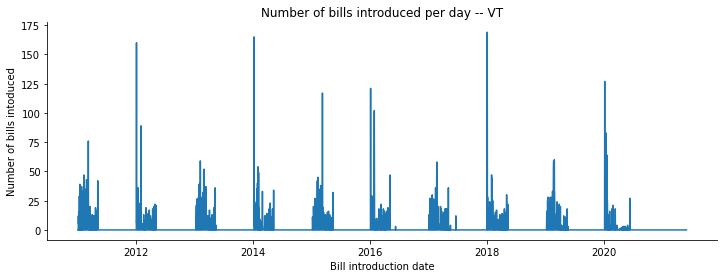

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
sns.lineplot(data=temp_bill_introduction, x='index', y='num_bills', ax=ax)
ax.set_xlabel('Bill introduction date')
ax.set_ylabel('Number of bills intoduced')
ax.set_title('Number of bills introduced per day -- {}'.format(state))
sns.despine(left=False, bottom=False)
# fig.savefig('deep_dive_figs/bills_introduced_by_day_{}.png'.format(state), bbox_inches='tight')

# How many bills do we have for the state in question?

In [ ]:
q = """
    select 
        count(distinct bill_id) as num_bills
    from clean_2.bills join clean_2.sessions using (session_id)
    where state='{}'
""".format(state)

In [ ]:
tot_bills = pd.read_sql(q, db_con)['num_bills'].iloc[0]
tot_bills

### What's the fraction of bills end up getting passed? 

In [ ]:
q = """
    with state_bills as (
        select 
            bill_id,
            a.state_id,
            state,
            introduced_date
        from clean_2.bills a join clean_2.sessions b using (session_id)
        where state='{}' and not special
    ),
    pass_details as (
        with conclusions as (
            select 
                bill_id,
                max(case when (event=4 or event=5 or event=6) then progress_date end) as conclude_date
            from clean_2.bill_progress group by bill_id
        )
        select 
            bill_id,
            max((case when (progress_date=conclude_date and event=4) then progress_date end)) as passed_date,
            max((case when (progress_date=conclude_date and event=4) then true end)::int) as passed
        from conclusions left join clean_2.bill_progress using (bill_id)
        group by bill_id
    )
    select 
        bill_id,
        state,
        passed_date,
        passed,
        introduced_date,
        (passed_date::DATE - introduced_date::DATE)::int as days_to_pass
    from state_bills join pass_details using (bill_id)
    where passed=1
    """.format(state)

In [ ]:
bills_passed = pd.read_sql(q, db_con)
num_bills_passed = bills_passed.shape[0]

In [ ]:
print('fraction of bills passed: {}%'.format(num_bills_passed/tot_bills*100))

In [ ]:
q = """
    select bill_id, introduced_date, extract('year' from introduced_date) as bill_year from clean_2.bills 
    where state='{}' 
""".format(state)

all_bills = pd.read_sql(q, db_con)

In [ ]:
all_bills = all_bills.merge(bills_passed, on=['bill_id', 'introduced_date'], how='left')
all_bills['passed'].fillna(0, inplace=True)

In [ ]:
all_bills.group

In [16]:
all_bills.head()

NameError: name 'all_bills' is not defined

In [ ]:
sns.barplot(
    data=all_bills,
    x='bill_year',
    y='passed',
    hue=''
)

### How long does it take to pass bills on average?

In [37]:
t1 = bills_passed['days_to_pass'].median()
t2 = bills_passed['days_to_pass'].mean()
print('median {} and mean {} days to pass a bill in {}'.format(round(t1), round(t2), state))

median 2 and mean 36 days to pass a bill in VT


In [38]:
bills_passed['days_to_pass'].quantile(q=0.90)

115.0

In [39]:
bills_passed['days_to_pass'].max()

509

### Distribution of days to get a bill passed 

No handles with labels found to put in legend.


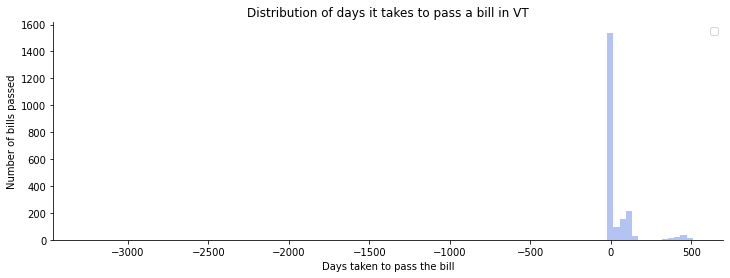

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
sns.distplot(bills_passed['days_to_pass'], kde=False, ax=ax, bins=100, color='royalblue')
ax.set_xlabel('Days taken to pass the bill')
ax.set_ylabel('Number of bills passed')
ax.set_title('Distribution of days it takes to pass a bill in {}'.format(state))

# specific to PA
# plt.axvline(x=7, label='label window---7 days', color='orange')
# plt.annotate('out of all bills, ~15% bills get passed within 7 days', xy=(15, 3000))
# plt.annotate('out of bills that gets passed, ~53% bills get passed within 7 days', xy=(15, 2500))
sns.despine(left=False, bottom=False)
plt.legend()
# fig.savefig('deep_dive_figs/bill_pass_days_dist_{}.png'.format(state), bbox_inches='tight')

In [309]:
# bills_passed['days_to_pass'].describe()

#### Fraction of bills that get passed within a certain number of days

In [41]:
d = 60
msk = bills_passed['days_to_pass'] <= d
t = bills_passed[msk].shape[0] / tot_bills
print('Out of all bills, {}% bills get passed within {} days'.format(round(t*100, 2), d))

t = bills_passed[msk].shape[0]/bills_passed.shape[0]
print('Out of bills that get passed, {}% bills get passed within {} days'.format(round(t*100, 2), d))

Out of all bills, 29.26% bills get passed within 60 days
Out of bills that get passed, 79.14% bills get passed within 60 days
